In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./data/BTCUSDT_2020.csv")

In [3]:
df_open = pd.DataFrame([df.dateTime, df.open]).T

In [4]:
df_open.describe()

,dateTime,open
count,147235,147235.00
unique,147235,142549.00
top,2020-01-01 00:00:00,29449.99
freq,1,7.00


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [6]:
df_open.open = df_open.open.astype('float32')

In [7]:
df_open.drop(columns = ['dateTime'], inplace = True)

In [8]:
scaled = scaler.fit_transform(df_open)

In [9]:
df_scaled = pd.DataFrame(scaled)

In [10]:
df_scaled.head()

,0
0,0.047427
1,0.047223
2,0.047183
3,0.047199
4,0.047158


In [11]:
train_size = int(len(df_scaled) * 0.8)
test_size = len(df_scaled) - train_size
train, test = df_scaled[:train_size], df_scaled[train_size:]

In [12]:
device = 'cuda'

In [13]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset.iloc[i:i+lookback].values
        target = dataset.iloc[i+lookback].values[0]
        X.append(feature)
        y.append(target)

    return torch.Tensor(X), torch.Tensor(y)

In [14]:
lookback = 100
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

C:\Users\denis\AppData\Local\Temp\ipykernel_99920\764325122.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.Tensor(X), torch.Tensor(y)


torch.Size([117688, 100, 1]) torch.Size([117688])
torch.Size([29347, 100, 1]) torch.Size([29347])


In [15]:
import torch.nn as nn
from torch.nn import functional

In [16]:
class QuantileLoss(nn.Module):
    def __init__(self, t = 0.1):
        super(QuantileLoss, self).__init__()
        self.t = t
    def forward(self, preds, target):
        errors = preds - target
        if torch.le(errors, 0):
            loss = (1 + t) * functional.smooth_l1_loss(preds, target) 
        else:
            loss = t * functional.smooth_l1_loss(preds, target)
        return loss.mean()

In [17]:
class BTCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=512, num_layers=1, batch_first=True)
        self.linear = nn.Linear(512, 512)
        self.projection = nn.Linear(512, 1)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p = 0.1)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.dropout(self.linear(self.non_lin(x)))
        x = self.dropout(self.linear(self.non_lin(x)))
        x = self.projection(self.non_lin(x))

        return x

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
from tqdm.auto import tqdm
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = BTCModel().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-6)
loss_fn = nn.MSELoss()
Q_Loss = QuantileLoss()
MAE = nn.SmoothL1Loss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=128)
eval_loader = data.DataLoader(data.TensorDataset(X_test, y_test), shuffle = False, batch_size = 128)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in tqdm(loader, desc=f'Training epoch {epoch}:'):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch)
        loss = Q_Loss(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    test_rmse = []
    test_mae = []
    with torch.no_grad():
        for X_batch, y_batch in eval_loader:
          X_batch = X_batch.to(device)
          y_batch = y_batch.to(device)
          y_pred = model(X_batch)
          test_rmse.append(torch.sqrt(loss_fn(y_pred, y_batch)).item())
          test_mae.append(MAE(y_pred, y_batch).item())

    av_mae = sum(test_mae)/len(test_mae)
    av_rmse = sum(test_rmse)/len(test_rmse)
    print("Epoch %d: test RMSE %.4f test MAE %.4f" % (epoch, av_rmse, av_mae))

AssertionError: Torch not compiled with CUDA enabled

In [105]:
preds = []
real = []

with torch.no_grad():
        model = model.to('cpu')
        for X_batch, y_batch in eval_loader:
            preds += model(X_batch).flatten().tolist()
            real += y_batch.flatten().tolist()

In [106]:
len(preds)

2934700

In [107]:
len(real)

29347

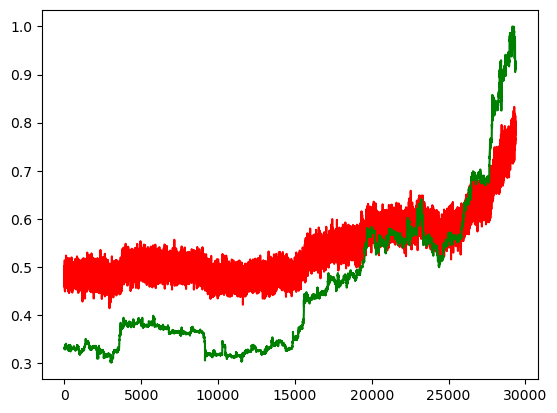

In [108]:
plt.plot(preds[::100], c='r')
plt.plot(y_test, c='g')
plt.show()

In [51]:
NAME = input('name: ')
torch.save(model.state_dict(), f'./models/{NAME}.pt')